# Tasks (Read prediction)

Since we don’t have access to the test labels, we’ll need to simulate validation/test sets of our own. So, let’s split the training data (‘train Interactions.csv.gz’) as follows:

(1) Reviews 1-190,000 for training

(2) Reviews 190,001-200,000 for validation

(3) Upload to Kaggle for testing only when you have a good model on the validation set. This will save you time (since Kaggle can take several minutes to return results), and prevent you from exceeding your daily submission limit.

In [116]:
# ============ Environment Setup ============
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# import some packages
import gzip
import random
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict

def splitDataset(datapath):
    """
    Split the training data (‘train Interactions.csv.gz’) as follows:
    (1) Reviews 1-190,000 for training
    (2) Reviews 190,001-200,000 for validation
    :param datapath:
    :return: train, valid as dataframe
    """
    f = gzip.open(datapath, 'rt')
    data = pd.read_csv(f)
    train, valid = data[:190001], data[190001:]
    return data, train, valid

data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

## Question 1

Although we have built a validation set, it only consists of positive samples. For this task we also need examples of user/item pairs that weren’t read. For each entry (user,book) in the validation set, sample a negative entry by randomly choosing a book that user hasn’t read. Evaluate the performance (accuracy) of the baseline model on the validation set you have built (1 mark).

In [117]:
def sampleNegative(data, train, valid):
    """
    For each entry (user,book) in the validation set, sample a negative entry
        by randomly choosing a book that user hasn’t read.
    :param train:
    :param valid:
    :return:
    """
    valid['read'] = 1
    NegValid = valid

    userBookDict = {}
    print("Preprocessing Data userBookDict ...")
    for index, row in tqdm(data.iterrows()):
        if row['userID'] not in userBookDict:
            userBookDict[row['userID']] = {row['bookID']}
        else:
            userBookDict[row['userID']].add(row['bookID'])

    for index, row in tqdm(valid.iterrows()):
        samNegBookID = random.sample(set(data['bookID']) - userBookDict[row['userID']], 1)[0]
        NegValid = NegValid.append({'userID': row['userID'], 'bookID': samNegBookID, 'rating': 0, 'read':0}, ignore_index=True)

    return NegValid, userBookDict 

In [118]:
def baselineOnValidation():
    random.seed(5583)
    data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
    print("Sampling Negative samples ...")
    valid, _ = sampleNegative(data, train, valid)

    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in tqdm(train.iterrows()):
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalRead / 2:
            break

    print('Evaluating ...')
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        if row['bookID'] in return1:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    print('Accuracy on Validation set is %.3f' % (correct/len(valid)))

baselineOnValidation()

Sampling Negative samples ...
Preprocessing Data userBookDict ...



Training ...



Evaluating ...



Accuracy on Validation set is 0.644


## Question 2

The existing ‘read prediction’ baseline just returns True if the item in question is ‘popular,’ using a threshold of the 50th percentile of popularity (totalRead/2). Assuming that the ‘non-read’ test examples are a random sample of user-book pairs, this threshold may not be the best one. See if you can find a better threshold and report its performance on your validatin set (1 mark).

Sampling Negative samples ...
Preprocessing Data userBookDict ...



Training ...
Evaluating on threshold 1 ...
Evaluating on threshold 2 ...
Evaluating on threshold 3 ...
Evaluating on threshold 4 ...
Evaluating on threshold 5 ...
Evaluating on threshold 6 ...
Evaluating on threshold 7 ...
Evaluating on threshold 8 ...
Evaluating on threshold 9 ...
Evaluating on threshold 10 ...


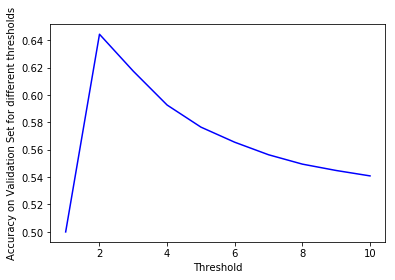

In [119]:
import matplotlib.pyplot as plt

def baselineOnValidation():
    random.seed(5583)
    data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
    print("Sampling Negative samples ...")
    valid, _ = sampleNegative(data, train, valid)
    
    acc = []
    thresholds = list(range(1, 11))
    
    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in train.iterrows():
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    for threshold in thresholds:
        return1 = set()
        count = 0
        for ic, i in mostPopular:
            count += ic
            return1.add(i)
            if count > totalRead / threshold:
                break

        print('Evaluating on threshold %d ...' % threshold)
        correct = 0
        for index, row in valid.iterrows():
            if row['bookID'] in return1:
                correct += (row['read'] != 0)
            else:
                correct += (row['read'] == 0)

        acc.append(correct/len(valid))

    plt.plot(thresholds, acc, 'b-')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy on Validation Set for different thresholds')
    plt.show()
    
baselineOnValidation()

As we can see, the best accuracy on validation set was achieved at threshold around $1.9$. And the accuracy is around $0.647$.

## Question 3

A stronger baseline than the one provided might make use of the Jaccard similarity (or another similarity metric). Given a pair (u, b) in the validation set, consider all training items b′ that user u has read. For each, compute the Jaccard similarity between b and b', i.e., users (in the training set) who have read b and users who have read b'. Predict as ‘read’ if the maximum of these Jaccard similarities exceeds a threshold (you may choose the threshold that works best). Report the performance on your validation set (1 mark).

In [120]:
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

Sampling Negative samples ...
Preprocessing Data userBookDict ...


Evaluating on threshold 0.500 ...



Evaluating on threshold 0.250 ...



Evaluating on threshold 0.125 ...



Evaluating on threshold 0.062 ...



Evaluating on threshold 0.031 ...



Evaluating on threshold 0.016 ...



Evaluating on threshold 0.008 ...



Evaluating on threshold 0.004 ...



Evaluating on threshold 0.002 ...


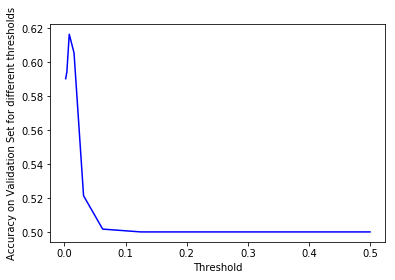

In [121]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

thresholds = [1/2**i for i in range(1, 10)]
acc = []
for threshold in thresholds:
    print('Evaluating on threshold %.3f ...' % threshold)
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        jac = []
        for book in userReads:
            if row['bookID'] not in BookwasRead:
                jac.append(0)
            else:
                jac.append(Jaccard(BookwasRead[row['bookID']], BookwasRead[book]))
                
        if max(jac) > threshold:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    acc.append(correct/len(valid))

plt.plot(thresholds, acc, 'b-')
plt.xlabel('Threshold')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

In [122]:
print('threshold %.3f, accuracy %.3f' % (thresholds[acc.index(max(acc))], max(acc)))

threshold 0.008, accuracy 0.616


## Question 4

Improve the above predictor by incorporating both a Jaccard-based threshold and a popularity based threshold. Report the performance on your validation set (1 mark).

Simply Use a "and" operation for ensemble model.

In [123]:
# preprocessing
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

Sampling Negative samples ...
Preprocessing Data userBookDict ...


In [124]:
def ensemble(threshold_pop = 1.9, threshold_jac = 0.008):
    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in train.iterrows():
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalRead / threshold_pop:
            break
    
    print('Evaluating ...')
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        jac = []
        for book in userReads:
            if row['bookID'] not in BookwasRead:
                jac.append(0)
            else:
                jac.append(Jaccard(BookwasRead[row['bookID']], BookwasRead[book]))

        if max(jac) > threshold_jac and row['bookID'] in return1:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)

    return correct/len(valid)
    
print("Accuracy is %.3f" % ensemble())

Training ...
Evaluating ...



Accuracy is 0.651


If we use the best thresholds from the single popularity and Jaccard method, the accuracy is 0.650. However, since in the ensemble model, we simply do a "and" operation, we should properly lower the thresholds.

###  Tune on Popularity Threshold

In [125]:
threshold_pops = [i/10 for i in range(10, 20)]
acc = []
for threshold_pop in threshold_pops:
    acc.append(ensemble(threshold_pop, threshold_jac = 0.008))

Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...


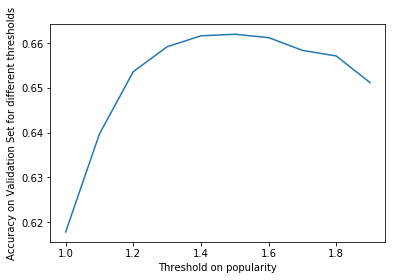

In [126]:
plt.plot(threshold_pops, acc)
plt.xlabel('Threshold on popularity')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

The best accuracy was achieved at threshold 1.4 as 0.663.

In [127]:
max(acc)

0.6619661966196619

### Tune on Jaccard Threshold

In [128]:
threshold_jacs = [i/10000 for i in range(50, 100, 10)]
acc = []
for threshold_jac in threshold_jacs:
    acc.append(ensemble(threshold_pop=1.4, threshold_jac=threshold_jac))

Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...


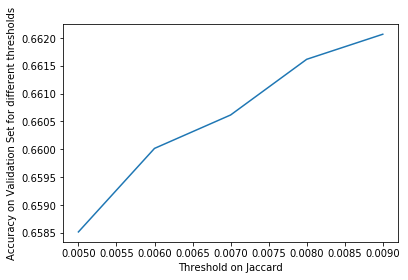

In [129]:
plt.plot(threshold_jacs, acc)
plt.xlabel('Threshold on Jaccard')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

According to the previous experiments, the best results 0.663 are achieved at the popularity threshold = 1.4, Jaccard threshold = 0.008.

## Question 5

To run our model on the test set, we’ll have to use the files ‘pairs Read.txt’ to find the reviewerID/itemID pairs about which we have to make predictions. Using that data, run the above model and upload your solution to Kaggle. Tell us your Kaggle user name (1 mark). If you’ve already uploaded a better solution to Kaggle, that’s fine too!

In [130]:
threshold_pop = 1.4
threshold_jac = 0.008

bookCount = defaultdict(int)
totalRead = 0

print('Training ...')
for index, row in train.iterrows():
    bookCount[row['bookID']] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRead / threshold_pop:
        break

predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    userReads = userReadBook[u]
    jac = []
    for book in userReads:
        if b not in BookwasRead:
            jac.append(0)
        else:
            jac.append(Jaccard(BookwasRead[b], BookwasRead[book]))

    if max(jac) > threshold_jac and b in return1:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

predictions.close()

Training ...


## Assignment 1

### Method 1: Adjusting Jaccard

In [131]:
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

Sampling Negative samples ...
Preprocessing Data userBookDict ...


Evaluating on threshold 0.500 ...



Evaluating on threshold 0.250 ...



Evaluating on threshold 0.125 ...



Evaluating on threshold 0.062 ...



Evaluating on threshold 0.031 ...



Evaluating on threshold 0.016 ...



Evaluating on threshold 0.008 ...



Evaluating on threshold 0.004 ...



Evaluating on threshold 0.002 ...


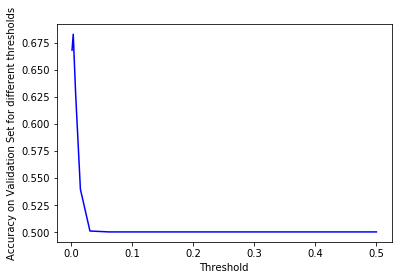

In [132]:
thresholds = [1/2**i for i in range(1, 10)]
acc = []
for threshold in thresholds:
    print('Evaluating on threshold %.3f ...' % threshold)
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        allbooks_ = set({})
        for book in userReads:
            allbooks_ = allbooks_.union(BookwasRead[book])

        if row['bookID'] not in BookwasRead:
            jac = 0
        else:
            jac = Jaccard(BookwasRead[row['bookID']], allbooks_)
                
        if jac > threshold:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    acc.append(correct/len(valid))

plt.plot(thresholds, acc, 'b-')
plt.xlabel('Threshold')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

In [133]:
max(acc)

0.6826682668266827

Evaluating on threshold 0.00300 ...



Evaluating on threshold 0.00310 ...



Evaluating on threshold 0.00320 ...



Evaluating on threshold 0.00330 ...



Evaluating on threshold 0.00340 ...



Evaluating on threshold 0.00350 ...



Evaluating on threshold 0.00360 ...



Evaluating on threshold 0.00370 ...



Evaluating on threshold 0.00380 ...



Evaluating on threshold 0.00390 ...


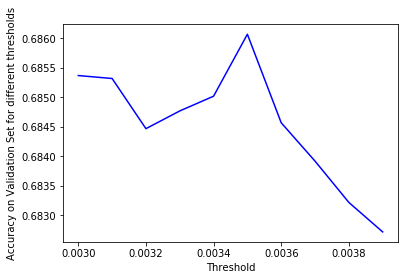

In [134]:
thresholds = [i/10000 for i in range(30, 40)]
acc = []
for threshold in thresholds:
    print('Evaluating on threshold %.5f ...' % threshold)
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        allbooks_ = set({})
        for book in userReads:
            allbooks_ = allbooks_.union(BookwasRead[book])

        if row['bookID'] not in BookwasRead:
            jac = 0
        else:
            jac = Jaccard(BookwasRead[row['bookID']], allbooks_)
                
        if jac > threshold:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    acc.append(correct/len(valid))

plt.plot(thresholds, acc, 'b-')
plt.xlabel('Threshold')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

In [135]:
max(acc)

0.686068606860686

In [136]:
threshold = 0.0035
predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    userReads = userReadBook[u]
    
    allbooks_ = set({})
    for book in userReads:
        allbooks_ = allbooks_.union(BookwasRead[book])

    if b not in BookwasRead:
        jac = 0
    else:
        jac = Jaccard(BookwasRead[b], allbooks_)
        
    if jac > threshold:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

predictions.close()

kaggle: 0.69983, using threshold=0.0035

### Method 2: Using Validation for Training

In [137]:
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(data.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

threshold = 0.0035
predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    userReads = userReadBook[u]
    
    allbooks_ = set({})
    for book in userReads:
        allbooks_ = allbooks_.union(BookwasRead[book])

    if b not in BookwasRead:
        jac = 0
    else:
        jac = Jaccard(BookwasRead[b], allbooks_)
        
    if jac > threshold:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

predictions.close()

Sampling Negative samples ...
Preprocessing Data userBookDict ...


kaggle: 0.70383

### Using Multi-Hop Jaccard + Popularity

In [138]:
# preprocessing
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

Sampling Negative samples ...
Preprocessing Data userBookDict ...


In [139]:
def ensemble(threshold_pop = 1.4, threshold_jac = 0.0035):
    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in train.iterrows():
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalRead / threshold_pop:
            break
    
    print('Evaluating ...')
    
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        allbooks_ = set({})
        for book in userReads:
            allbooks_ = allbooks_.union(BookwasRead[book])

        if row['bookID'] not in BookwasRead:
            jac = 0
        else:
            jac = Jaccard(BookwasRead[row['bookID']], allbooks_)

        if jac > threshold_jac and row['bookID'] in return1:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)

    return correct/len(valid)
    
print("Accuracy is %.3f" % ensemble())

Training ...
Evaluating ...



Accuracy is 0.677


#### Tune on Popularity Threshold

In [140]:
threshold_pops = [i/10 for i in range(5, 25)]
acc = []
for threshold_pop in threshold_pops:
    acc.append(ensemble(threshold_pop, threshold_jac = 0.0035))

Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...


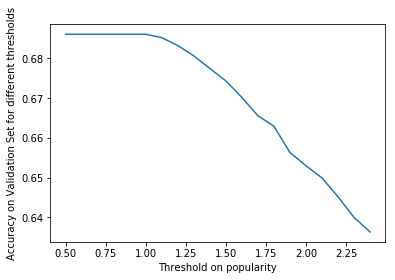

In [141]:
plt.plot(threshold_pops, acc)
plt.xlabel('Threshold on popularity')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

In [142]:
max(acc)

0.686068606860686

#### Tune on Jaccard Threshold

In [143]:
threshold_jacs = [i/10000 for i in range(10, 50, 5)]
acc = []
for threshold_jac in threshold_jacs:
    acc.append(ensemble(threshold_pop=1.0, threshold_jac=threshold_jac))

Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...


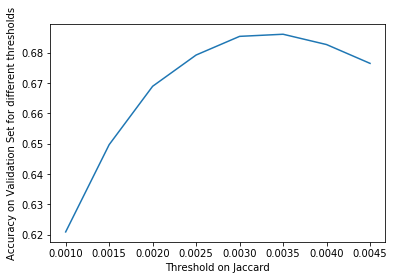

In [144]:
plt.plot(threshold_jacs, acc)
plt.xlabel('Threshold on Jaccard')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

In [145]:
max(acc)

0.686068606860686

#### Predicting without Training on validation

In [146]:
threshold_pop = 1
threshold_jac = 0.0035

bookCount = defaultdict(int)
totalRead = 0

print('Training ...')
for index, row in train.iterrows():
    bookCount[row['bookID']] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRead / threshold_pop:
        break

predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    userReads = userReadBook[u]
    
    allbooks_ = set({})
    for book in userReads:
        allbooks_ = allbooks_.union(BookwasRead[book])

    if b not in BookwasRead:
        jac = 0
    else:
        jac = Jaccard(BookwasRead[b], allbooks_)
        
    if jac > threshold and b in return1:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

predictions.close()

Training ...


kaggle: 0.69583

#### Predicting with Training on validation

In [ ]:
threshold_pop = 1
threshold_jac = 0.0035

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(data.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

bookCount = defaultdict(int)
totalRead = 0

print('Training ...')
for index, row in data.iterrows():
    bookCount[row['bookID']] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRead / threshold_pop:
        break

predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    userReads = userReadBook[u]
    
    allbooks_ = set({})
    for book in userReads:
        allbooks_ = allbooks_.union(BookwasRead[book])

    if b not in BookwasRead:
        jac = 0
    else:
        jac = Jaccard(BookwasRead[b], allbooks_)
        
    if jac > threshold and b in return1:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

predictions.close()

### 50% + 50%

In [197]:
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(data.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

In [211]:
pre_dict = {}
book_user_book = {}

for l in tqdm(open("./data/pairs_Read.txt")):
    if l.startswith("userID"):
        # header
        continue
    u, b = l.strip().split('-')

    if b not in book_user_book:
        books_ = set({})
        for user in BookwasRead[b]:
            books_ = books_.union(userReadBook[user])
        book_user_book[b] = books_
    books = book_user_book[b]
    
    jacs = []

    userReads = userReadBook[u]  # books user read
    for book in userReads:
        if book not in book_user_book:
            books_ = set({})
            for user in BookwasRead[book]:
                books_ = books_.union(userReadBook[user])
            book_user_book[book] = books_
        jac = Jaccard(books, book_user_book[book])
        jacs.append(jac)
        
    if u not in pre_dict:
        pre_dict[u] = {b:np.max(jacs)}
    else:
        pre_dict[u][b] = np.max(jacs)

In [212]:
pre_dict

{'u65407115': {'b69897799': 0.08583690987124463,
  'b25623896': 0.2296195652173913},
 'u53740605': {'b39436893': 0.11926605504587157,
  'b50552757': 0.11180124223602485,
  'b01987205': 0.2883895131086142,
  'b89076881': 0.30874572051042637},
 'u88031275': {'b83889575': 0.07762260474179929,
  'b12429909': 0.09055118110236221,
  'b38702078': 0.05555555555555555,
  'b23583350': 0.1162109375,
  'b55315814': 0.38701236917221693,
  'b17438614': 0.036585365853658534},
 'u99759913': {'b39270822': 0.13643533123028392,
  'b24168787': 0.08261211644374508,
  'b01425053': 0.1149032992036405,
  'b06202654': 0.04672192916352675},
 'u20090895': {'b47380623': 0.25543041029766694,
  'b08169279': 0.06537530266343826,
  'b30404568': 0.18212253096752595,
  'b06290657': 0.16614137775776677,
  'b73869874': 0.1874730021598272,
  'b44294326': 0.037037037037037035},
 'u24294545': {'b66431497': 0.16139767054908485,
  'b76125166': 0.11707126076742365},
 'u55512157': {'b82932751': 0.102609464838567,
  'b91268579':

In [213]:
import operator

pre_ = {}

for user in pre_dict.keys():
    pre_[user] = {}
    tmp = sorted(pre_dict[user].items(), key=operator.itemgetter(1), reverse=True)
    for index in range(len(tmp)):
        if index <= (len(tmp)/2-1):
            pre_[user][tmp[index][0]] = 1
        else:
            pre_[user][tmp[index][0]] = 0
            
pre_

{'u65407115': {'b25623896': 1, 'b69897799': 0},
 'u53740605': {'b89076881': 1, 'b01987205': 1, 'b39436893': 0, 'b50552757': 0},
 'u88031275': {'b55315814': 1,
  'b23583350': 1,
  'b12429909': 1,
  'b83889575': 0,
  'b38702078': 0,
  'b17438614': 0},
 'u99759913': {'b39270822': 1, 'b01425053': 1, 'b24168787': 0, 'b06202654': 0},
 'u20090895': {'b47380623': 1,
  'b73869874': 1,
  'b30404568': 1,
  'b06290657': 0,
  'b08169279': 0,
  'b44294326': 0},
 'u24294545': {'b66431497': 1, 'b76125166': 0},
 'u55512157': {'b16489787': 1,
  'b51077306': 1,
  'b48755561': 1,
  'b50338484': 1,
  'b91268579': 0,
  'b46314542': 0,
  'b82932751': 0,
  'b75386676': 0},
 'u49944817': {'b22036626': 1,
  'b05533804': 1,
  'b45622320': 1,
  'b08859581': 0,
  'b19421886': 0,
  'b77890333': 0},
 'u25738103': {'b45622320': 1, 'b40864764': 0},
 'u60899187': {'b27621138': 1, 'b88168757': 0},
 'u02807468': {'b95188078': 1, 'b65726547': 0},
 'u34858646': {'b90557194': 1,
  'b67545669': 1,
  'b01552513': 1,
  'b70895

In [214]:
predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    predictions.write(u + '-' + b + "," + str(pre_[u][b]) + "\n")
    
predictions.close()

### Kaggle

User name: shihanran

Display name: Shihan Ran

Email: sran@ucsd.edu

Public Leaderboard Score: 0.67466

# Tasks (Rating prediction)

Let’s start by building our training/validation sets much as we did for the first task. This time building a validation set is more straightforward: you can simply use part of the data for validation, and do not need to randomly sample non-read users/books.

## Question 9

Fit a predictor of the form

$$\text { rating (user, item ) } \simeq \alpha+\beta_{\text {user }}+\beta_{\text {item }}$$

by fitting the mean and the two bias terms as described in the lecture notes. Use a regularization parameter of $\lambda = 1$. Report the MSE on the validation set (1 mark).

In [ ]:
import scipy
import scipy.optimize
import numpy as np

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userID'], d['bookID']) for index, d in train.iterrows()]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for index, d in train.iterrows():
        u,i = d['userID'], d['bookID']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return np.array(dtheta)

### Training 

In [ ]:
lamb = 1
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

ratingMean = train['rating'].mean()
alpha = ratingMean

labels = train['rating']

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

users = list(set(train['userID']))
items = list(set(train['bookID']))
nUsers = len(users)
nItems = len(items)

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb))

### Validating

In [ ]:
predictions = []
for index, d in valid.iterrows():
    u, i = d['userID'], d['bookID']
    if u in userBiases and i in itemBiases:
        predictions.append(prediction(u, i))
    else:
        predictions.append(0)

print("MSE %.3f" % MSE(predictions, valid['rating']))

## Question 10

Report the user and book IDs that have the largest and smallest values of $\beta$ (1 mark).

In [ ]:
print("max user: %s , max value: %f" % (max(userBiases, key=userBiases.get), max(userBiases.values())))
print("max book: %s , max value: %f" % (max(itemBiases, key=itemBiases.get), max(itemBiases.values())))
print("min user: %s , min value: %f" % (min(userBiases, key=userBiases.get), min(userBiases.values())))
print("min book: %s , min value: %f" % (min(itemBiases, key=itemBiases.get), min(itemBiases.values())))

## Question 11

Find a better value of λ using your validation set. Report the value you chose, its MSE, and upload your solution to Kaggle by running it on the test data (1 mark).

### Tune on Lambda

#### Training

In [ ]:
lamb = 10**(-5)

def training(lamb):
    scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb))
    
training(lamb)

#### Validating

In [ ]:
predictions = []
for index, d in valid.iterrows():
    u, i = d['userID'], d['bookID']
    if u in userBiases and i in itemBiases:
        predictions.append(prediction(u, i))
    else:
        predictions.append(0)

print("MSE %.3f" % MSE(predictions, valid['rating']))

#### Predicting on Test

In [ ]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("./data/pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u, i = l.strip().split('-')
    if u in userBiases and i in itemBiases:
        predictions.write(u + '-' + i + ',' + str(prediction(u, i)) + '\n')
    else:
        predictions.write(u + '-' + i + ',' + str(0) + '\n')

predictions.close()

# Assignment 1

## Using valid to train

### Codes from hw3 solution

In [ ]:
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

ratingsTrain = train
ratingsValid = valid

ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for index, row in ratingsTrain.iterrows():
    u, b, r = row['userID'], row['bookID'], row['rating']
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))
    
trainRatings = ratingsTrain['rating']
globalAverage = sum(trainRatings) * 1.0 / len(trainRatings)

In [ ]:
betaU = {}
betaI = {}
for u in ratingsPerUser:
    betaU[u] = 0

for b in ratingsPerItem:
    betaI[b] = 0

alpha = globalAverage # Could initialize anywhere, this is a guess

In [ ]:
def iterate(lamb):
    newAlpha = 0
    for index, row in ratingsTrain.iterrows():
        u, b, r = row['userID'], row['bookID'], row['rating']
        newAlpha += r - (betaU[u] + betaI[b])
    alpha = newAlpha / len(ratingsTrain)
    for u in ratingsPerUser:
        newBetaU = 0
        for b,r in ratingsPerUser[u]:
            newBetaU += r - (alpha + betaI[b])
        betaU[u] = newBetaU / (lamb + len(ratingsPerUser[u]))
    for b in ratingsPerItem:
        newBetaI = 0
        for u,r in ratingsPerItem[b]:
            newBetaI += r - (alpha + betaU[u])
        betaI[b] = newBetaI / (lamb + len(ratingsPerItem[b]))
    mse = 0
    for index, row in ratingsTrain.iterrows():
        u, b, r = row['userID'], row['bookID'], row['rating']
        prediction = alpha + betaU[u] + betaI[b]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU:
        regularizer += betaU[u]**2
    for b in betaI:
        regularizer += betaI[b]**2
    mse /= len(ratingsTrain)
    return mse, mse + lamb*regularizer

In [ ]:
mse,objective = iterate(1)
newMSE,newObjective = iterate(1)
iterations = 1

while iterations < 10 or objective - newObjective > 0.0001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(5)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

In [ ]:
validMSE = 0
for index, row in ratingsValid.iterrows():
    u, b, r = row['userID'], row['bookID'], row['rating']
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if b in betaI:
        bi = betaI[b]
    prediction = alpha + bu + bi
    validMSE += (r - prediction)**2

validMSE /= len(ratingsValid)
print("Validation MSE = " + str(validMSE))

In [ ]:
predictions = open("./predictions_Rating.txt", 'w')
for l in open("./data/pairs_Rating.txt"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,b = l.strip().split('-')
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if b in betaI:
        bi = betaI[b]
    _ = predictions.write(u + '-' + b + ',' + str(alpha + bu + bi) + '\n')

predictions.close()

### Codes from workbook4

In [107]:
import scipy
import scipy.optimize
import numpy as np

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userID'], d['bookID']) for index, d in train.iterrows()]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb_u*userBiases[u]**2
    for i in itemBiases:
        cost += lamb_i*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for index, d in train.iterrows():
        u,i = d['userID'], d['bookID']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb_u*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb_i*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return np.array(dtheta)

In [ ]:
lamb_u = 1e-5
lamb_i = 15*1e-6
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
train = data

ratingMean = train['rating'].mean()
alpha = ratingMean

labels = train['rating']

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

users = list(set(train['userID']))
items = list(set(train['bookID']))
nUsers = len(users)
nItems = len(items)

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb_u, lamb_i))

In [ ]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("./data/pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u, i = l.strip().split('-')
    if u in userBiases and i in itemBiases:
        predictions.write(u + '-' + i + ',' + str(prediction(u, i)) + '\n')
    else:
        predictions.write(u + '-' + i + ',' + str(0) + '\n')

predictions.close()

In [227]:
def prediction(user, item):
    pred = alpha + userBiases[user] + itemBiases[item]
    return pred

def prediction_(user, item):
    pred = alpha + userBiases[user] + itemBiases[item]
    if pred > 5:
        return 5.0
    elif pred < 0:
        return 0
    elif abs(round(pred) - pred) <= 0.005:
        return round(pred)
    return pred

In [222]:
import scipy
import scipy.optimize
import numpy as np

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userID'], d['bookID']) for index, d in train.iterrows()]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in users:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in items:
        dItemGamma[i] = [0.0 for k in range(K)]
    for index, d in train.iterrows():
        u,i = d['userID'], d['bookID']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return np.array(dtheta)

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

In [226]:
lamb = 10**(-5)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
train = data

ratingMean = train['rating'].mean()
alpha = ratingMean

labels = train['rating']

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

users = list(set(train['userID']))
items = list(set(train['bookID']))
nUsers = len(users)
nItems = len(items)

userGamma = {}
itemGamma = {}

K = 2

for u in users:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in items:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K1*(nUsers+nItems))], # Gamma
                             derivative, args = (labels, lamb), maxiter=20)

MSE = 1.4744154699735492
MSE = 1.4570350351674028
MSE = 1.3935472771685433
MSE = 7.9045061666013625
MSE = 1.3694164377402511
MSE = 1.2061367614476726
MSE = 1.2046116171342238
MSE = 1.1986064494130675
MSE = 1.176112331048995
MSE = 1.0625268168398758
MSE = 1.0102965549710154
MSE = 0.9823618402726455
MSE = 0.9684824116559728
MSE = 0.9573329014220102
MSE = 0.9433019419806621
MSE = 0.9300267686813957
MSE = 0.925753343336907
MSE = 0.9238295769416089
MSE = 1.232532873264863
MSE = 0.9238321654758205
MSE = 0.9220042869884157
MSE = 0.9204643796107445
MSE = 0.9191380802415152
MSE = 0.9178071163919993
MSE = 0.9206031200435133
MSE = 0.917919145540926
MSE = 0.9150516422826317
MSE = 0.9169960751327552


(array([ 3.80775350e+00, -4.12433705e-01,  6.77189169e-01, ...,
         5.66574566e-02, -2.46518227e-03,  8.46901735e-02]),
 0.9676540265852476,
 {'grad': array([-1.30336724e-03,  1.17319671e-06,  2.26257074e-06, ...,
         -3.33153254e-06, -2.06809046e-06, -7.29044635e-06]),
  'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT',
  'funcalls': 28,
  'nit': 20,
  'warnflag': 1})

In [228]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("./data/pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u, i = l.strip().split('-')
    if u in userBiases and i in itemBiases:
        predictions.write(u + '-' + i + ',' + str(prediction_(u, i)) + '\n')
    else:
        predictions.write(u + '-' + i + ',' + str(0) + '\n')

predictions.close()

## Using Round

In [160]:
def prediction(user, item):
    pred = alpha + userBiases[user] + itemBiases[item]
    return pred

def prediction_(user, item):
    pred = alpha + userBiases[user] + itemBiases[item]
    if pred > 5:
        return 5.0
    elif pred < 0:
        return 0
    elif abs(round(pred) - pred) <= 0.005:
        return round(pred)
    return pred

In [151]:
lamb = 1e-5
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
train = data

ratingMean = train['rating'].mean()
alpha = ratingMean

labels = train['rating']

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

users = list(set(train['userID']))
items = list(set(train['bookID']))
nUsers = len(users)
nItems = len(items)

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb))

MSE = 1.4744154699735492
MSE = 1.4570319169995913
MSE = 1.393533889858659
MSE = 7.89945243504263
MSE = 1.369402053679339
MSE = 1.2061413235697607
MSE = 1.204617105879512
MSE = 1.1986155977261617
MSE = 1.1761353668365062
MSE = 1.0625453360285297
MSE = 1.0103244429088203
MSE = 0.9823492886744852
MSE = 0.9684425963408375
MSE = 0.9573302706523766
MSE = 0.9432751391089027
MSE = 0.9300804084823305
MSE = 0.9258996288401794
MSE = 0.9240337661974436
MSE = 0.9255245805008668
MSE = 0.923314379727117
MSE = 0.9211183759319219
MSE = 0.9196917954439785
MSE = 0.9187092367602108
MSE = 0.9187008034087604
MSE = 0.9241627052195361
MSE = 0.9181636590114657
MSE = 0.9180841738088579
MSE = 0.9173058237093225
MSE = 0.916850239077917
MSE = 0.9162552704135991
MSE = 0.9153591340193575
MSE = 0.9152322490881715
MSE = 0.9151875234805992
MSE = 0.915202385885959
MSE = 0.9151947728226614
MSE = 0.9151884793110435
MSE = 0.9150765977677177
MSE = 0.9154916282669823
MSE = 0.91510907606243
MSE = 0.9150918406225206
MSE = 0.91

(array([ 3.80803741, -0.42462631,  0.67502395, ..., -0.03220637,
         0.45967632, -0.09165582]),
 0.9659434778941021,
 {'grad': array([ 8.72481005e-06,  1.01976971e-08, -3.48285771e-08, ...,
         -8.73711959e-09, -9.32054524e-09,  3.21534426e-08]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 174,
  'nit': 140,
  'warnflag': 0})

In [161]:
predictions = []
for index, d in valid.iterrows():
    u, i = d['userID'], d['bookID']
    if u in userBiases and i in itemBiases:
        predictions.append(prediction_(u, i))
    else:
        predictions.append(0)

print("MSE %.3f" % MSE(predictions, valid['rating']))

MSE 0.922


In [162]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("./data/pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u, i = l.strip().split('-')
    if u in userBiases and i in itemBiases:
        predictions.write(u + '-' + i + ',' + str(prediction_(u, i)) + '\n')
    else:
        predictions.write(u + '-' + i + ',' + str(0) + '\n')

predictions.close()